In [1]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
import seaborn as snb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(strategy='mean')

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_log_error

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
# Jalamos los datos del dataset
data_train = pd.read_csv('house_train_raw.csv', encoding='utf-8', sep=',')
data_test = pd.read_csv('houses_test_raw.csv', encoding='utf-8', sep=',')
dataf = pd.concat((data_train, data_test)).reset_index(drop=True)


In [3]:
# Obtenemos inforación del dataset
dataf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [4]:
# Obtenemos el número de registros y columnas del dataset
dataf.shape

(2919, 81)

In [5]:
# Imprimimos en pantalla los 5 primeros registros
dataf.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [6]:
# Creamos una función que devuleva un dataframe con el conteo y porcentaje de nulos
def porcentaje_nulos(col=''):
  null_counts = pd.DataFrame()
  null_counts['conteo'] = dataf.isnull().sum()
  null_counts = null_counts[null_counts['conteo']>0].reset_index()
  null_counts['porcentaje'] = (null_counts['conteo']/dataf.shape[0] * 100).round(2)
  if col in ['','all']:
    return null_counts
  return null_counts['porcentaje'].loc[null_counts['index'] == col][0]


In [7]:
porcentaje_nulos()

,index,conteo,porcentaje
0,MSZoning,4,0.14
1,LotFrontage,486,16.65
2,Alley,2721,93.22
3,Utilities,2,0.07
4,Exterior1st,1,0.03
5,Exterior2nd,1,0.03
6,MasVnrType,24,0.82
7,MasVnrArea,23,0.79
8,BsmtQual,81,2.77
9,BsmtCond,82,2.81


In [8]:
# Rellenamos la columna ['MSZoning'] con la moda, ya que el porcentaje de nulos es menos del 1%
dataf['MSZoning']= dataf['MSZoning'].fillna(dataf['MSZoning'].mode()[0])
porcentaje_nulos()

,index,conteo,porcentaje
0,LotFrontage,486,16.65
1,Alley,2721,93.22
2,Utilities,2,0.07
3,Exterior1st,1,0.03
4,Exterior2nd,1,0.03
5,MasVnrType,24,0.82
6,MasVnrArea,23,0.79
7,BsmtQual,81,2.77
8,BsmtCond,82,2.81
9,BsmtExposure,82,2.81


In [9]:
# Rellenamos la columna 'LotFrontage' con su promedio porque es numérico y el porcentaje de nulos es menos del 17%
dataf['LotFrontage']= dataf['LotFrontage'].fillna(dataf['LotFrontage'].mean())
porcentaje_nulos()

,index,conteo,porcentaje
0,Alley,2721,93.22
1,Utilities,2,0.07
2,Exterior1st,1,0.03
3,Exterior2nd,1,0.03
4,MasVnrType,24,0.82
5,MasVnrArea,23,0.79
6,BsmtQual,81,2.77
7,BsmtCond,82,2.81
8,BsmtExposure,82,2.81
9,BsmtFinType1,79,2.71


In [10]:
# Eliminamos la columna, ya que contiene un 93.22 % de nulos y a mi parecer no va a influir mucho en el resultado final
# porcentaje_nulos('Alley') -----> 93.22 %
dataf.drop(['Alley'], axis=1, inplace=True)
porcentaje_nulos()

,index,conteo,porcentaje
0,Utilities,2,0.07
1,Exterior1st,1,0.03
2,Exterior2nd,1,0.03
3,MasVnrType,24,0.82
4,MasVnrArea,23,0.79
5,BsmtQual,81,2.77
6,BsmtCond,82,2.81
7,BsmtExposure,82,2.81
8,BsmtFinType1,79,2.71
9,BsmtFinSF1,1,0.03


In [11]:
# Rellenamos las columnas ['Utilities','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea'] con la moda, ya que el porcentaje de nulos es menos del 1% cada uno.
columnas = ['Utilities','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea']
for columna in columnas:
  dataf[columna] = dataf[columna].fillna(dataf[columna].mode()[0])
porcentaje_nulos()

,index,conteo,porcentaje
0,BsmtQual,81,2.77
1,BsmtCond,82,2.81
2,BsmtExposure,82,2.81
3,BsmtFinType1,79,2.71
4,BsmtFinSF1,1,0.03
5,BsmtFinType2,80,2.74
6,BsmtFinSF2,1,0.03
7,BsmtUnfSF,1,0.03
8,TotalBsmtSF,1,0.03
9,Electrical,1,0.03


In [12]:
# Rellenamos las columnas con la moda ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF'] porque son de tipo objeto
# además los nulos de cada columna no pasan del 3% cada uno.

columnas = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']
for col in columnas:
  # print(f"porcentaje_nulos('{col}') -----> {porcentaje_nulos(col)} %")
  dataf[col] = dataf[col].fillna(dataf[col].mode()[0])
porcentaje_nulos()

,index,conteo,porcentaje
0,Electrical,1,0.03
1,BsmtFullBath,2,0.07
2,BsmtHalfBath,2,0.07
3,KitchenQual,1,0.03
4,Functional,2,0.07
5,FireplaceQu,1420,48.65
6,GarageType,157,5.38
7,GarageYrBlt,159,5.45
8,GarageFinish,159,5.45
9,GarageCars,1,0.03


In [13]:
#  Rellenamos las columnas con la moda ['Electrical','BsmtFullBath','BsmtHalfBath','KitchenQual','Functional','SaleType'] porque es de tipo objeto, además no pasan del 1% cada uno.
columnas = ['Electrical','BsmtFullBath','BsmtHalfBath','KitchenQual','Functional','SaleType']
for columna in columnas:
  dataf[columna] = dataf[columna].fillna(dataf[columna].mode()[0])
porcentaje_nulos()

,index,conteo,porcentaje
0,FireplaceQu,1420,48.65
1,GarageType,157,5.38
2,GarageYrBlt,159,5.45
3,GarageFinish,159,5.45
4,GarageCars,1,0.03
5,GarageArea,1,0.03
6,GarageQual,159,5.45
7,GarageCond,159,5.45
8,PoolQC,2909,99.66
9,Fence,2348,80.44


In [14]:
# Eliminanos los registros que no contienen valor en el año de construcción en la columna ['GarageYrBlt']
dataf.dropna(subset=['GarageYrBlt'], inplace=True)
porcentaje_nulos()

,index,conteo,porcentaje
0,FireplaceQu,1276,46.23
1,PoolQC,2750,99.64
2,Fence,2218,80.36
3,MiscFeature,2663,96.49
4,SalePrice,1381,50.04


In [15]:
# Reemplazamos los valor nulos por el valor NA que significa (No Fireplace)
dataf['FireplaceQu'] = dataf['FireplaceQu'].fillna('NA')
# dataf['FireplaceQu'].value_counts()
porcentaje_nulos()

,index,conteo,porcentaje
0,PoolQC,2750,99.64
1,Fence,2218,80.36
2,MiscFeature,2663,96.49
3,SalePrice,1381,50.04


In [16]:
# Eliminamos las columnas ['PoolQC','Fence','MiscFeature'], porque sobrepasan el 80% de nulos.
columnas = ['PoolQC','Fence','MiscFeature']
dataf.drop(columns=columnas, axis=1, inplace=True)
porcentaje_nulos()

,index,conteo,porcentaje
0,SalePrice,1381,50.04


In [17]:
# Verificamos si hay duplicados
dataf.duplicated().sum()

0

In [18]:
# Volvemos a verificar el número de registros y columnas
dataf.shape

(2760, 77)

In [19]:
dataf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2760 entries, 0 to 2918
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2760 non-null   int64  
 1   MSSubClass     2760 non-null   int64  
 2   MSZoning       2760 non-null   object 
 3   LotFrontage    2760 non-null   float64
 4   LotArea        2760 non-null   int64  
 5   Street         2760 non-null   object 
 6   LotShape       2760 non-null   object 
 7   LandContour    2760 non-null   object 
 8   Utilities      2760 non-null   object 
 9   LotConfig      2760 non-null   object 
 10  LandSlope      2760 non-null   object 
 11  Neighborhood   2760 non-null   object 
 12  Condition1     2760 non-null   object 
 13  Condition2     2760 non-null   object 
 14  BldgType       2760 non-null   object 
 15  HouseStyle     2760 non-null   object 
 16  OverallQual    2760 non-null   int64  
 17  OverallCond    2760 non-null   int64  
 18  YearBuil

In [20]:
# Recodificamos la columna ['MSSubClass'] para tomarlo en cuenta como categórico y no numérico
dataf['MSSubClass'] = dataf['MSSubClass'].apply(lambda x : "MSSC"+str(x))

In [21]:
# Seperamos las columnas de tipo Objeto y numérico
col_objets = []
for i in dataf.columns:
    if dataf[i].dtype == object:
        col_objets.append(i)

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
col_numerics = []
for i in dataf.columns:
    if dataf[i].dtype in numeric_dtypes:
        col_numerics.append(i)

In [22]:
print(f"El número de columas de tipo objeto son: {len(col_objets)}")
print(f"El número de columas de tipo numérico son: {len(col_numerics)}")

El número de columas de tipo objeto son: 40
El número de columas de tipo numérico son: 37


In [23]:
col_objets

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [24]:
col_numerics

['Id',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [25]:
# Extraemos sólo las columnas que son numéricas
df_final_numerics = dataf[col_numerics]

In [26]:
# Definimos una función que me permite aplicar Onehotencoder
def category_onehotencoder(cols, df_encoder):
    onehot_encoder = OneHotEncoder(sparse = False)
    df_ = df_final_numerics.copy()
    for col in cols:
        col_encoder = df_encoder[col].values.reshape(-1,1)
        onehot_encoder.fit(col_encoder)
        cols_encoded = onehot_encoder.transform(col_encoder)

        for i, e in enumerate(onehot_encoder.categories_[0]):
            df_[e+"_encode"] = cols_encoded[:,i]
    return df_

In [27]:
# Asignamos a la variable 'df_final_encode' el resultado del Onehotencoder
df_final_encode = category_onehotencoder(col_objets,dataf)

/var/folders/rz/0d_g_df14hn4j_5kyrct5lg00000gn/T/ipykernel_61886/1499502634.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[e+"_encode"] = cols_encoded[:,i]
/var/folders/rz/0d_g_df14hn4j_5kyrct5lg00000gn/T/ipykernel_61886/1499502634.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[e+"_encode"] = cols_encoded[:,i]
/var/folders/rz/0d_g_df14hn4j_5kyrct5lg00000gn/T/ipykernel_61886/1499502634.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

## Entrenando con modelo Árbol de Decisión (onehotencoder y numéricas)

In [28]:
# Contamos los registros que contengan valor en la columna ['SalePrice] para diferenciar el dataframe train con el test
conteo_train_ad = len(df_final_encode[(~df_final_encode.SalePrice.isnull())])

In [29]:
# Separando X_df_train_ad e X_df_test_ad
X_df_train_ad = df_final_encode.iloc[:conteo_train_ad,:]
y_df_train_ad = X_df_train_ad.SalePrice.values

X_df_test_ad = df_final_encode.iloc[conteo_train_ad:,:]

In [30]:
# Eliminamos la columna ['Id','SalePrice] de ambos dataframes
X_df_train_ad.drop(['Id','SalePrice'], axis=1, inplace=True)
X_df_test_ad.drop(['Id','SalePrice'], axis=1, inplace=True)

In [31]:
# Creamos un objeto árbol y hacemos el split del dataframe
tree = DecisionTreeClassifier()

X_train_ad, X_test_ad, y_train_ad, y_test_ad = train_test_split(X_df_train_ad, y_df_train_ad, test_size=0.33, random_state=42)

In [32]:
# Entrenamos el modelo
tree.fit(X_train_ad, y_train_ad)

DecisionTreeClassifier()

In [33]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred_ad = tree.predict(X_train_ad)

# Predecimos sobre nuestro set de test
y_test_pred_ad = tree.predict(X_test_ad)

# Comaparamos con las etiquetas reales
print('Accuracy sobre el dataset "house_train_raw" para el Train:', accuracy_score(y_train_pred_ad,y_train_ad))
print('Accuracy sobre el dataset "house_train_raw" para el Test:', accuracy_score(y_test_pred_ad,y_test_ad))

Accuracy sobre el dataset "house_train_raw" para el Train: 1.0
Accuracy sobre el dataset "house_train_raw" para el Test: 0.0043859649122807015


In [43]:
print('La raíz cuadrada del error logarítmico medio (RMSLE) sobre el dataset houses_train_raw es:', mean_squared_log_error(y_test_pred_ad, y_test_ad, squared=False))

La raíz cuadrada del error logarítmico medio (RMSLE) sobre el dataset houses_train_raw es: 0.2740773241041003


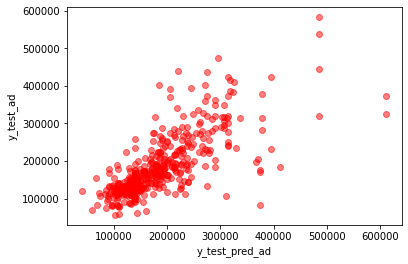

In [46]:
plt.scatter(y_test_pred_ad, y_test_ad, c="r", alpha=0.5)
plt.xlabel("y_test_pred_ad")
plt.ylabel("y_test_ad")
# plt.legend(loc='upper left')
plt.show()

### Predecimos la columna SalePrice del dataset "houses_test_raw.csv"

In [36]:
y_test_pred_raw = tree.predict(X_df_test_ad)
pd.DataFrame(y_test_pred_raw, columns=['SalePrice']).to_csv("pred_test_ad.csv", index=False, sep=",")

## Usando el modelo "Extreme Gradient Boosting"
https://medium.com/@jboscomendoza/tutorial-xgboost-en-python-53e48fc58f73

In [37]:
# Importamos la librería
import xgboost as xgb

In [38]:
# Contamos los registros que contengan valor en la columna ['SalePrice] para diferenciar el dataframe train con el test
conteo_train_xgb = len(df_final_encode[(~df_final_encode.SalePrice.isnull())])

# Separando X_df_train_xgb e X_df_test_xgb
X_df_train_xgb = df_final_encode.iloc[:conteo_train_xgb,:]
y_df_train_xgb = X_df_train_xgb.SalePrice.values

X_df_test_xgb = df_final_encode.iloc[conteo_train_xgb:,:]

# Eliminamos la columna ['Id','SalePrice] de ambos dataframes
X_df_train_xgb.drop(['Id','SalePrice'], axis=1, inplace=True)
X_df_test_xgb.drop(['Id','SalePrice'], axis=1, inplace=True)

In [39]:
# Creamos el objeto XGBRegressor y hacemos el split
modelo_xgb = xgb.XGBRegressor()
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_df_train_ad, y_df_train_ad, test_size=0.33, random_state=42)

# Entrenamos el modelo XGBRegressor
modelo_xgb.fit(X_train_xgb, y_train_xgb)

# Predecimos sobre nuestro set de entrenamieto
y_train_pred_xgb = modelo_xgb.predict(X_train_xgb)

# Predecimos sobre nuestro set de test
y_test_pred_xgb = modelo_xgb.predict(X_test_xgb)


In [44]:
# Imprimimos el la raíz cuadrada del error logarítmico medio
print('La raíz cuadrada del error logarítmico medio (RMSLE) sobre el dataset houses_train_raw es:', mean_squared_log_error(y_test_pred_xgb,y_test_xgb, squared=False))

La raíz cuadrada del error logarítmico medio (RMSLE) sobre el dataset houses_train_raw es: 0.15062214763507542


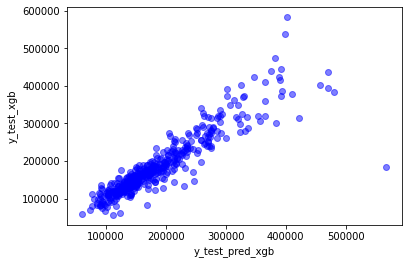

In [45]:
plt.scatter(y_test_pred_xgb, y_test_xgb, c="b", alpha=0.5)
plt.xlabel("y_test_pred_xgb")
plt.ylabel("y_test_xgb")
# plt.legend(loc='upper left')
plt.show()

In [42]:
# Predecimos el target 'SalePrice' para el dataset houses_test_raw
xgb_preds_test=modelo_xgb.predict(X_df_test_xgb)
pd.DataFrame(xgb_preds_test, columns=['SalePrice']).to_csv("pred_test.csv", index=False, sep=",")